# Inference: Generate SLO from Vessel Masks (Colab)

Loads a trained checkpoint from Drive and generates synthetic SLO images.

Default checkpoint path:
`/content/drive/MyDrive/Kodiak/STORAGE/fake_slo/runs/slo_unet_v6e1/best.pt`
        


In [1]:
from google.colab import drive

drive.mount('/content/drive')
        


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip -q install --upgrade numpy Pillow
        


In [3]:
from pathlib import Path

CHECKPOINT_PATH = Path('/content/drive/MyDrive/Kodiak/STORAGE/fake_slo/runs/slo_unet_v6e1/best.pt')
MASK_INPUT = Path('/content/drive/MyDrive/Kodiak/STORAGE/fake_slo/SLO_VESSELS')
OUTPUT_DIR = Path('/content/drive/MyDrive/Kodiak/STORAGE/fake_slo/runs/slo_unet_v6e1/generated')

# Optional override. Leave None to use training dimensions from checkpoint.
IMAGE_WIDTH = None
IMAGE_HEIGHT = None

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print('Checkpoint exists:', CHECKPOINT_PATH.exists())
print('Mask input exists:', MASK_INPUT.exists())
print('Output dir:', OUTPUT_DIR)
        


Checkpoint exists: True
Mask input exists: True
Output dir: /content/drive/MyDrive/Kodiak/STORAGE/fake_slo/runs/slo_unet_v6e1/generated


In [4]:
import re
from typing import List

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image

VALID_IMAGE_SUFFIXES = {'.png', '.jpg', '.jpeg', '.tif', '.tiff', '.bmp'}


class DoubleConv(nn.Module):
    def __init__(self, in_ch: int, out_ch: int):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.LeakyReLU(0.1, inplace=True),
        )

    def forward(self, x):
        return self.block(x)


class Down(nn.Module):
    def __init__(self, in_ch: int, out_ch: int):
        super().__init__()
        self.pool_conv = nn.Sequential(nn.MaxPool2d(2), DoubleConv(in_ch, out_ch))

    def forward(self, x):
        return self.pool_conv(x)


class Up(nn.Module):
    def __init__(self, in_ch: int, skip_ch: int, out_ch: int):
        super().__init__()
        self.conv = DoubleConv(in_ch + skip_ch, out_ch)

    def forward(self, x, skip):
        x = F.interpolate(x, size=skip.shape[-2:], mode='bilinear', align_corners=False)
        x = torch.cat([skip, x], dim=1)
        return self.conv(x)


class UNetGenerator(nn.Module):
    def __init__(self, in_ch: int = 1, out_ch: int = 1, base_ch: int = 32):
        super().__init__()
        self.in_conv = DoubleConv(in_ch, base_ch)
        self.down1 = Down(base_ch, base_ch * 2)
        self.down2 = Down(base_ch * 2, base_ch * 4)
        self.down3 = Down(base_ch * 4, base_ch * 8)
        self.bottleneck = Down(base_ch * 8, base_ch * 8)

        self.up1 = Up(base_ch * 8, base_ch * 8, base_ch * 4)
        self.up2 = Up(base_ch * 4, base_ch * 4, base_ch * 2)
        self.up3 = Up(base_ch * 2, base_ch * 2, base_ch)
        self.up4 = Up(base_ch, base_ch, base_ch)
        self.out_conv = nn.Conv2d(base_ch, out_ch, kernel_size=1)

    def forward(self, x):
        x1 = self.in_conv(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        xb = self.bottleneck(x4)
        x = self.up1(xb, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        return torch.sigmoid(self.out_conv(x))


def gather_mask_paths(mask_input: Path) -> List[Path]:
    if mask_input.is_file():
        return [mask_input]
    if not mask_input.is_dir():
        raise FileNotFoundError(f'Mask path not found: {mask_input}')

    candidates = [
        p
        for p in sorted(mask_input.iterdir())
        if p.is_file() and p.suffix.lower() in VALID_IMAGE_SUFFIXES and re.search(r'vessels|mask', p.stem, re.IGNORECASE)
    ]
    if not candidates:
        raise ValueError(f'No mask images found in {mask_input}')
    return candidates


def load_mask(mask_path: Path, width: int, height: int) -> torch.Tensor:
    with Image.open(mask_path) as img:
        img = img.convert('L')
        img = img.resize((width, height), resample=Image.Resampling.NEAREST)
        arr = np.asarray(img, dtype=np.float32) / 255.0
    return torch.from_numpy(arr).unsqueeze(0).unsqueeze(0)


def save_image(tensor: torch.Tensor, out_path: Path) -> None:
    out_path.parent.mkdir(parents=True, exist_ok=True)
    arr = tensor.squeeze().detach().cpu().numpy().clip(0, 1)
    Image.fromarray((arr * 255.0).astype(np.uint8), mode='L').save(out_path)
        


In [5]:
checkpoint = torch.load(CHECKPOINT_PATH, map_location='cpu')
train_args = checkpoint.get('args', {})

image_width = IMAGE_WIDTH or int(train_args.get('image_width', 1024))
image_height = IMAGE_HEIGHT or int(train_args.get('image_height', 512))
base_channels = int(train_args.get('base_channels', 32))

model = UNetGenerator(base_ch=base_channels)
model.load_state_dict(checkpoint['model_state'])
model.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print('Torch:', torch.__version__)
print('Device:', device)
print('Image size:', image_width, 'x', image_height)

mask_paths = gather_mask_paths(MASK_INPUT)
print('Mask count:', len(mask_paths))

for mask_path in mask_paths:
    x = load_mask(mask_path, width=image_width, height=image_height).to(device)
    with torch.no_grad():
        y = model(x)

    stem = mask_path.stem
    if 'vessels_' in stem.lower():
        suffix = stem.lower().split('vessels_', 1)[1]
        out_name = f'slo_synthetic_{suffix}.tiff'
    else:
        out_name = f'{stem}_synthetic_slo.tiff'

    out_path = OUTPUT_DIR / out_name
    save_image(y[0], out_path)
    print('Saved:', out_path)

print('Done. Generated to:', OUTPUT_DIR)
        


Torch: 2.9.0+cpu
Device: cpu
Image size: 1024 x 512
Mask count: 22
Saved: /content/drive/MyDrive/Kodiak/STORAGE/fake_slo/runs/slo_unet_v6e1/generated/slo_synthetic_1.tiff
Saved: /content/drive/MyDrive/Kodiak/STORAGE/fake_slo/runs/slo_unet_v6e1/generated/slo_synthetic_10.tiff
Saved: /content/drive/MyDrive/Kodiak/STORAGE/fake_slo/runs/slo_unet_v6e1/generated/slo_synthetic_11.tiff
Saved: /content/drive/MyDrive/Kodiak/STORAGE/fake_slo/runs/slo_unet_v6e1/generated/slo_synthetic_12.tiff
Saved: /content/drive/MyDrive/Kodiak/STORAGE/fake_slo/runs/slo_unet_v6e1/generated/slo_synthetic_13.tiff
Saved: /content/drive/MyDrive/Kodiak/STORAGE/fake_slo/runs/slo_unet_v6e1/generated/slo_synthetic_14.tiff
Saved: /content/drive/MyDrive/Kodiak/STORAGE/fake_slo/runs/slo_unet_v6e1/generated/slo_synthetic_15.tiff
Saved: /content/drive/MyDrive/Kodiak/STORAGE/fake_slo/runs/slo_unet_v6e1/generated/slo_synthetic_16.tiff
Saved: /content/drive/MyDrive/Kodiak/STORAGE/fake_slo/runs/slo_unet_v6e1/generated/slo_synthet

Generated files: 22


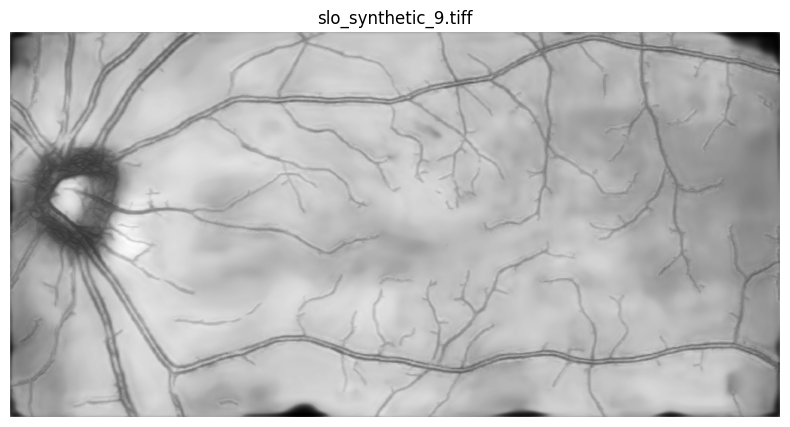

In [6]:
import matplotlib.pyplot as plt

generated = sorted(OUTPUT_DIR.glob('*.tif*'))
print('Generated files:', len(generated))
if generated:
    sample = generated[-1]
    with Image.open(sample) as img:
        plt.figure(figsize=(10, 5))
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(sample.name)
        plt.show()
        
